<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_colab_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Download the dataset

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 32
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data

##--------------------cifar10-----------------------------##
train_data = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
##--------------------FashionMNIST-----------------------------##
# train_data = torchvision.datasets.FashionMNIST(root="./", download=True, 
#                                               train=True,
#                                               transform=transforms)
# classes = () ##fashion mnist dataset classes
# 2.3 Use DataLoader to get batches and shuffle

train_data = list(train_data)
train_set = train_data[:20]     # 20 images
val_set   = train_data[200:2200]# 2000 images

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


cuda
Files already downloaded and verified


## 2. Vew some dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([9, 3, 9, 8, 9, 3, 4, 9, 1, 6, 9, 2, 1, 7, 4, 7, 2, 6, 7, 2])


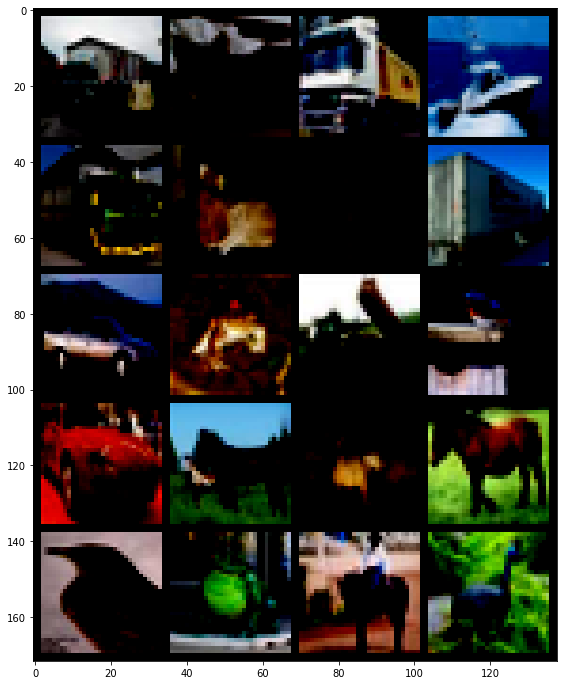

In [3]:
batch = next(iter(train_loader))
images, labels = batch
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) 

print(f"class labels: {labels}")
plt.imshow(grid.permute(1,2,0))

## 3. Define CutMix

In [4]:
def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [5]:
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)


In [6]:
original_images = images.clone().detach() 
bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


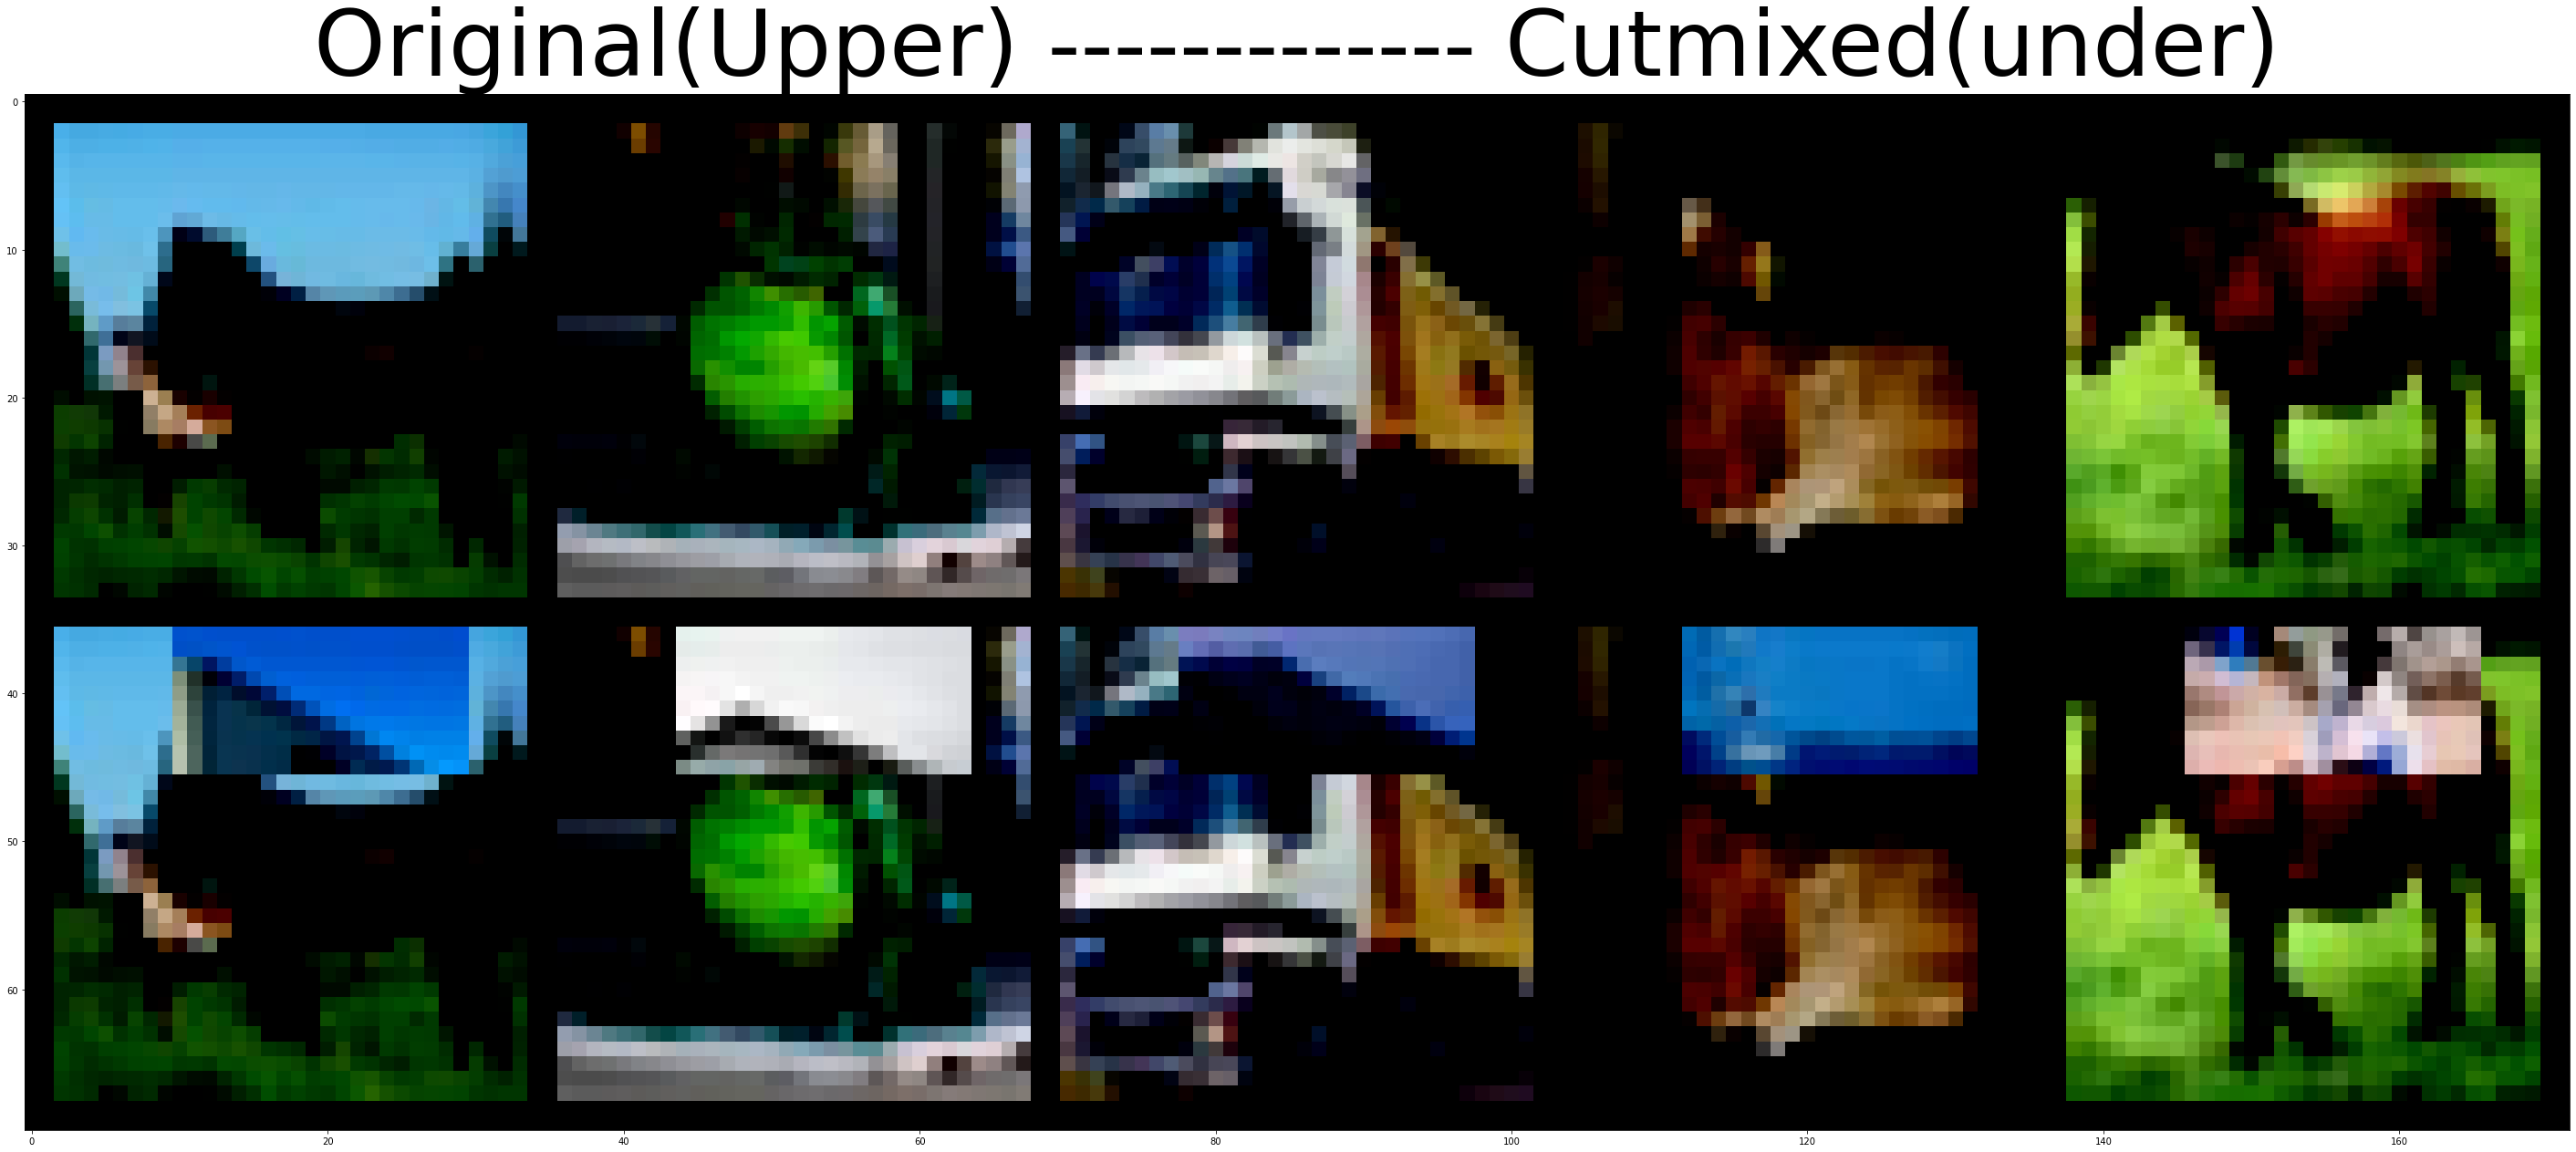

In [8]:
def show_cutMixed_compare(origin, new, nums_show):
    rand_index = torch.randperm(origin.size()[0])[:nums_show]
    to_compare = torch.cat([origin[rand_index,:,:],new[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.title("Original(Upper) ------------- Cutmixed(under)", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(original_images, images, 5)

## 4. Make model

In [27]:
from torch.nn import Linear
from torchvision import models

# VGG16 Model Loading
use_pretrained = True
model = models.vgg16(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(classes)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

## Check ##
## It will only print the layer that would be trained.(requires_grad == True)

for name, param in model.named_parameters():
  if param.requires_grad != False :
    print(name, end=" : ")
    print(param.requires_grad)

cuda
features.0.weight : True
features.0.bias : True
features.2.weight : True
features.2.bias : True
features.5.weight : True
features.5.bias : True
features.7.weight : True
features.7.bias : True
features.10.weight : True
features.10.bias : True
features.12.weight : True
features.12.bias : True
features.14.weight : True
features.14.bias : True
features.17.weight : True
features.17.bias : True
features.19.weight : True
features.19.bias : True
features.21.weight : True
features.21.bias : True
features.24.weight : True
features.24.bias : True
features.26.weight : True
features.26.bias : True
features.28.weight : True
features.28.bias : True
classifier.0.weight : True
classifier.0.bias : True
classifier.3.weight : True
classifier.3.bias : True
classifier.6.weight : True
classifier.6.bias : True
fc.weight : True
fc.bias : True


# 4. Change the way of TL.

<img src="https://drive.google.com/uc?id=1GWF6NdAg34NIT4JcDHtujofdy2bxQ53y" height =300 width = 300>


## IMPORTANT : You should run **only one** section from 4-1 to 4-4. And then move on to the training section.

## 4-1 Freeze the base. --> <img src="https://drive.google.com/uc?id=1ags6qiwR0ss3SnvO6wh5-6c6RfIn8p3Z" height =100 width = 100 align="middle"> 
Dataset Similarity( **High** ), Dataset Size( **Small** )

In [76]:
def tl4_1(model) :
  params_to_update = []
  update_params_name = ['classifier.6.weight', 'classifier.6.bias', 'fc.weight',
                        'fc.bias']

  for name, param in model.named_parameters():
      if name in update_params_name:
          param.requires_grad = True
          params_to_update.append(param)
          print(name)
      else:
          param.requires_grad = False
  return model, params_to_update
    

## 4-2 Train some layers and leave others frozen. --> <img src="https://drive.google.com/uc?id=1qMf4o07rJx9YLfxh1Ol-jKgJJueIUe4j" height =100 width = 100 align="middle"> 
Dataset Similarity( **High** ), Dataset Size( **High** )

In [77]:
def tl4_2(model) :
  params_to_update = []
  update_params_name = ['features.0.weight',
  'features.0.bias',
  'features.2.weight',
  'features.2.bias',
  'features.5.weight',
  'features.5.bias',
  'features.7.weight',
  'features.7.bias',
  'features.10.weight',
  'features.10.bias',
  'features.12.weight',
  'features.12.bias',
  'features.14.weight',
  'features.14.bias',
  'features.17.weight',
  'features.17.bias',
  'features.19.weight',
  'features.19.bias',
  'features.21.weight',
  'features.21.bias']

  for name, param in model.named_parameters():
      if name not in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
      else :
        param.requires_grad = False

  return model, params_to_update

## 4-3 Train some layers and leave others frozen. --> <img src="https://drive.google.com/uc?id=1zGGXr0aEaMUxf-5WfJ9J4-Lps-8BMMeW" height =100 width = 100 align="middle"> 
Dataset Similarity( **Low** ), Dataset Size( **Low** )

In [74]:
def tl4_3(model) :
  params_to_update = []
  update_params_name = ['features.0.weight',
  'features.0.bias',
  'features.2.weight',
  'features.2.bias',
  'features.5.weight',
  'features.5.bias',
  'features.7.weight',
  'features.7.bias']

  for name, param in model.named_parameters():
      if name not in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
      else :
        param.requires_grad = False

  return model, params_to_update

## 4-4 Train the entire model. --> <img src="https://drive.google.com/uc?id=1ZWTbY58t395U71j3lZqEePEZPXKky7T8" height =100 width = 100 align="middle"> 
Dataset Similarity( **Low** ), Dataset Size( **High** )

In [75]:
def tl4_4(model) :
  params_to_update = []
  update_params_name = []

  for name, param in model.named_parameters():
      if name not in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
      else :
        param.requires_grad = False
  
  return model, params_to_update

# After run one section among 4-1 to 4-4. 

## Run below cell.

In [78]:
## Check ##
## It will print all layers and whether the layer requirs grad or not.
model, params_to_update = tl4_2(model)
for name, param in model.named_parameters():
    print(name, end=" : ")
    print(param.requires_grad)

features.0.weight : False
features.0.bias : False
features.2.weight : False
features.2.bias : False
features.5.weight : False
features.5.bias : False
features.7.weight : False
features.7.bias : False
features.10.weight : False
features.10.bias : False
features.12.weight : False
features.12.bias : False
features.14.weight : False
features.14.bias : False
features.17.weight : False
features.17.bias : False
features.19.weight : False
features.19.bias : False
features.21.weight : False
features.21.bias : False
features.24.weight : True
features.24.bias : True
features.26.weight : True
features.26.bias : True
features.28.weight : True
features.28.bias : True
classifier.0.weight : True
classifier.0.bias : True
classifier.3.weight : True
classifier.3.bias : True
classifier.6.weight : True
classifier.6.bias : True
fc.weight : True
fc.bias : True


## 5. Start Training

In [ ]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params_to_update, lr=0.0005)

In [80]:
import torch.optim as optim
from tqdm.auto import tqdm, trange

def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval() # For later #
    for imgs, labels in dataloader :
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total

def train_model(model, 
                train, 
                valid, 
                n_iters=500, 
                learn_rate=0.001, 
                batch_size=128, 
                weight_decay=0,
                params_to_update=model.parameters(), 
                iscutmix=1):  # Lists to store model's performance information
  losses, train_acc, val_acc = [], [], []
  train_high, valid_high = 0, 0
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(params_to_update, lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

  for i in trange(n_iters):
    for images, labels in tqdm(iter(train_loader)):
      images, labels = images.to(device), labels.to(device)
      model.train() # For Dropout and Batch Norm layers #

      if iscutmix and (np.random.rand()<0.5) :

        lam = np.random.beta(1.0, 1.0)
        rand_index = torch.randperm(images.size()[0])

        shuffled_labels = labels[rand_index]
        bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
        images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))

        out = model(images)           # forward pass
        loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
      else :
        
        out = model(images)
        loss = criterion(out, labels)

      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # reset the gradients for the next iteration

    train_score = get_accuracy(model, train)
    valid_score = get_accuracy(model, valid)

    # if valid_score > valid_high :
    #   valid_high = valid_score
    #   torch.save(model.state_dict(), './model.pth')

    train_acc.append(train_score)
    val_acc.append(valid_score)
    losses.append(float(loss)/batch_size) 




  print(f'Plotting')
  # Plotting Training Loss, Accuracy and Validation Accuracy
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title("Training Curve")
  plt.plot(np.arange(n_iters), losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")

  plt.subplot(1,2,2)
  plt.title("Training Curve")
  plt.plot(np.arange(n_iters), train_acc, label="Train")
  plt.plot(np.arange(n_iters), val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Plotting


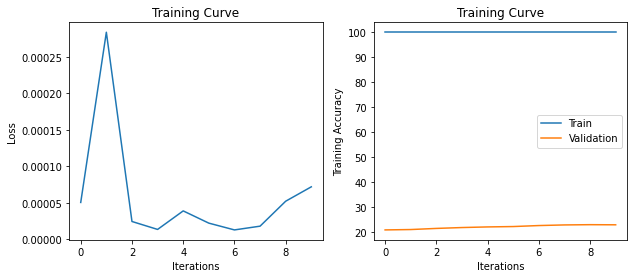

Final Training Accuracy: 100.0
Final Validation Accuracy: 22.75


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Plotting


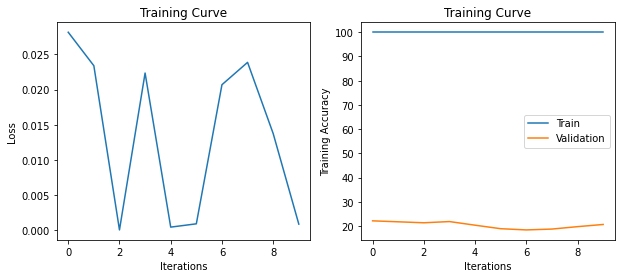

Final Training Accuracy: 100.0
Final Validation Accuracy: 20.6


In [68]:
#4-1#
model, params_to_update = tl4_1(model)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=0)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Plotting


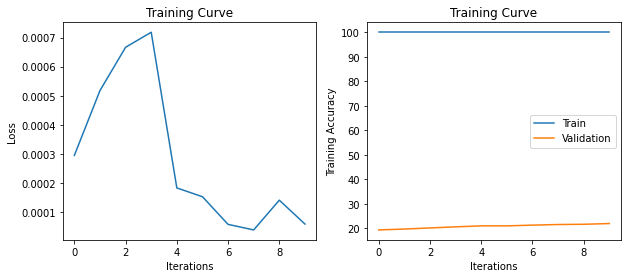

Final Training Accuracy: 100.0
Final Validation Accuracy: 22.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Plotting


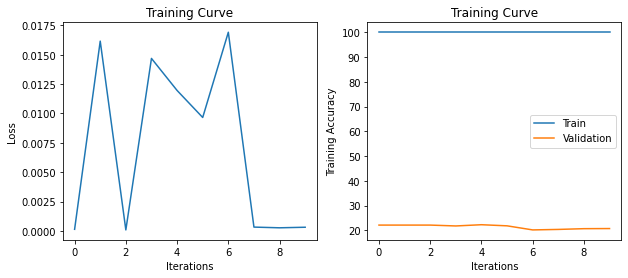

Final Training Accuracy: 100.0
Final Validation Accuracy: 20.7


In [79]:
#4-2
model, params_to_update = tl4_2(model)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=0)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Plotting


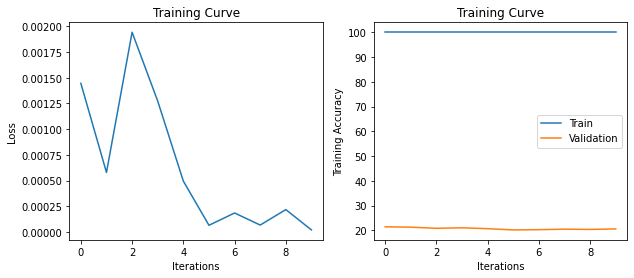

Final Training Accuracy: 100.0
Final Validation Accuracy: 20.6


In [65]:
#4-3
model, params_to_update = tl4_3(model)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=0)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=1)

In [ ]:
#4-4
model, params_to_update = tl4_4(model)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=0)
train_model(model, train_loader, test_loader, n_iters=10, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0,params_to_update=params_to_update, iscutmix=1)

## 6. Test the model

In [ ]:
get_accuracy(model, test_loader)

84.53